In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
path = '/content/drive/My Drive/EspecializacionUBA/Matematica/FiltrodeKalman/'

In [3]:
pos = pd.read_csv(path+'posicion.dat',sep="\s+",names=['t','x','y','z'])
vel = pd.read_csv(path+'velocidad.dat',sep="\s+",names=['t','x_','y_','z_'])
acc = pd.read_csv(path+'aceleracion.dat',sep="\s+",names=['t','x__','y__','z__'])

In [4]:
vehiculo = pd.concat([pos,vel[['x_','y_','z_']],acc[['x__','y__','z__']]],join='inner',axis=1)

In [ ]:
#pos_ = np.genfromtxt(path+'posicion.dat',dtype=[('t', 'float'), ('x', 'float'), ('y', 'float'),('z', 'float')])
#vel_ = np.genfromtxt(path+'velocidad.dat',dtype=[('t', 'float'), ('x', 'float'), ('y', 'float'),('z', 'float')])
#acc_ = np.genfromtxt(path+'aceleracion.dat',dtype=[('t', 'float'), ('x', 'float'), ('y', 'float'),('z', 'float')])

# Matrices necesarias para el algoritmo

In [5]:
# Creo el data set de predicciones con la posición inicial dada
predicciones_0_0 = pd.DataFrame({'x':[10.7533],'y':[36.6777],'z':[-45.1769],
                             'x_':[1.1009],'y_':[-17.0],'z_':[35.7418],
                             'x__':[-5.7247],'y__':[3.4268],'z__':[5.2774]})

In [6]:
#Matriz de covarianza de la posición inicial
P_0_0 = np.diag(v=[100, 100, 100, 1, 1, 1, 0.01, 0.01, 0.01],k=0)

In [7]:

Q =  np.eye(N=9,M=9) * 0.3

In [8]:
# Creo el data set de predicciones con la posición inicial dada
predicciones_0_0 = pd.DataFrame({'x':[10.7533],'y':[36.6777],'z':[-45.1769],
                             'x_':[1.1009],'y_':[-17.0],'z_':[35.7418],
                             'x__':[-5.7247],'y__':[3.4268],'z__':[5.2774]})

In [9]:
dT = 1 #Delta de tiempo medido

# Filas de la matriz de la dinámica del sistema
p_row = np.hstack( (np.eye(N=3,M=3),np.eye(N=3,M=3)* dT, np.eye(N=3,M=3)* (dT**2)/2) ) #Posición
v_row = np.hstack( (np.zeros(shape=(3,3)),np.eye(N=3,M=3), np.eye(N=3,M=3)* dT) ) #Velocidad
a_row = np.hstack( (np.zeros(shape=(3,3)),np.zeros(shape=(3,3)), np.eye(N=3,M=3)) ) # Aceleración

A = np.vstack((p_row,v_row,a_row)) # Matriz con la dinámica del sistema

In [10]:
C = np.hstack( (np.eye(N=3,M=3),np.zeros(shape=(3,3)), np.zeros(shape=(3,3))))

# Situacion 1: Ruido Gaussiano en la posicion

In [11]:
ruido_normal = np.random.normal(loc=0,scale=100,size=(5,3))
# Posicion con primeros 5 valores con ruido gaussiano
pos_gauss = pos.copy()
pos_gauss.iloc[:5,1:4] = pos_gauss.iloc[:5,1:4] + ruido_normal#+ 11

In [12]:
R = np.eye(N=3,M=3) *100

In [13]:
vehiculo = pd.concat([pos_gauss,vel[['x_','y_','z_']],acc[['x__','y__','z__']]],join='inner',axis=1)

In [14]:
arranque = np.array(predicciones_0_0.iloc[0,:])

In [15]:
# Creo el data set de predicciones con la posición inicial dada
predicciones_0_0 = pd.DataFrame({'x':[10.7533],'y':[36.6777],'z':[-45.1769],
                             'x_':[1.1009],'y_':[-17.0],'z_':[35.7418],
                             'x__':[-5.7247],'y__':[3.4268],'z__':[5.2774]})

In [16]:
def Kalman(Xinic, Pinic, mediciones, A, C, Q, R):
  #Holders
  base_register  = pd.DataFrame({'x':[],'y':[],'z':[],
                             'x_':[],'y_':[],'z_':[],
                             'x__':[],'y__':[],'z__':[]})
  #Xn1_n1 = base_register.copy()
  Xn_n1  = base_register.copy()
  Xn_n = base_register.copy()

  #Pn1_n1 = np.zeros(shape=(1,9,9))
  Pn_n1 = np.zeros(shape=(1,9,9))
  Pn_n = np.zeros(shape=(1,9,9))

  Kn = np.zeros(shape=(1,9,3))

  #Inicializo parámetros
  Xn_n.loc[0] = Xinic
  Pn_n = Pinic.reshape((1,9,9))

  #Algoritmo
  times = len(mediciones)
  for m in range(0,times):
    Xn_n1.loc[m] = A @ Xn_n.loc[m]
    
    Pn_n1 = np.append(Pn_n1, (A @ Pn_n[m] @ A.T + Q).reshape((1,9,9)) ,axis=0) # B Q B pero B es la identidad en este caso, así que la omitimos
    
    Kn =  np.append(Kn, (Pn_n1[m+1] @ C.T @ np.linalg.inv(C@Pn_n1[m+1]@C.T + R)).reshape(1,9,3),axis=0 )
    
    Xn_n.loc[m+1] = Xn_n1.loc[m] + Kn[m+1] @ (mediciones.iloc[m,1:4] - C @ Xn_n1.loc[m])
    
    Pn_n = np.append(Pn_n, ((np.eye(N=9,M=9) - Kn[m+1] @ C) @ Pn_n1[m+1]).reshape((1,9,9)),axis=0)
  
  return Xn_n



In [17]:
a = Kalman(arranque, P_0_0,  pos_gauss, A, C, Q, R)

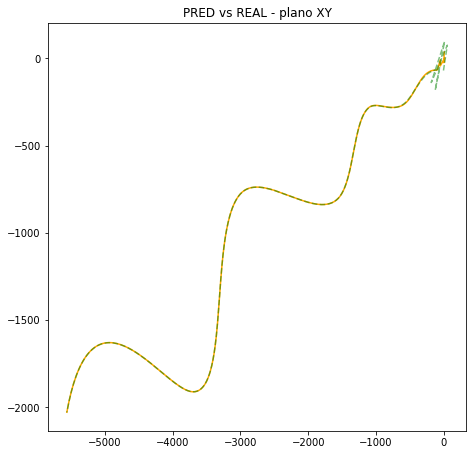

In [29]:
f, ax= plt.subplots(figsize=(7.5,7.5))

ax.plot(a.x,a.y,color='orange')

ax.plot(pos_gauss.x,pos_gauss.y,color='green',ls='--',alpha=0.5)
ax.set_title('PRED vs REAL - plano XY')
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
f = go.Figure()
#fig = px.scatter_3d(a, x='x', y='y', z='z')
f = px.scatter_3d(pos_gauss,'x','y','z')

f.show()

In [33]:
error = np.sqrt((a.x-pos_gauss.x)**2 + (a.z-pos_gauss.z)**2+ (a.z-pos_gauss.z)**2 )
error = error.fillna(0)
mse = error.sum()/len(error-1)
mse

123.97683191010924

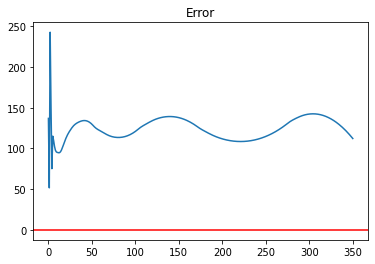

In [36]:
f, ax = plt.subplots()
ax.plot(error[:-1])
ax.axhline(y=0,color='red')
ax.set_title('Error')
plt.show()

124.198236670821

# Situación 2: Ruido uniforme en la posición

In [27]:
# Si el desvio es de 10 en una uniforme, hay que calcular el máximo, asumiendo que el minimo es en 0
# ver formula de varianza y queda como acá
ruido_uniforme = np.random.uniform(low=0,high=10*np.sqrt(12),size=(5,3))
# Posicion con primeros 5 valores con ruido gaussiano
pos_uni = pos.copy()
pos_uni = pos_uni.iloc[:5,1:4] + ruido_uniforme#+ 11

In [ ]:
# Actualizar la matriz R 
R_uni

In [ ]:
pred_uni = Kalman(a = Kalman(arranque, P_0_0,  pos_gauss, A, C, Q, R_uni))

# Situación 3: Ruido Gaussiano en posición y velocidad